# Mean state and biases in FOCI-OpenIFS

We are analysing the simulation FOCI_GJK001 performed on HLRN-Gottingen, late 2021. 
Tco95L91 + ORCA05L46

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cmocean 
import cartopy.feature as cfeature

In [2]:
from dask.distributed import Client, LocalCluster, wait

In [3]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

In [4]:
client

Client Scheduler: tcp://127.0.0.1:44013 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 59.60 GiB


In [6]:
machine = 'nesh'

if machine == 'sci':
    esmdir = '/data/user/jkjellsson/esm-experiments/focioifs/'
    nemo_mesh = '/data/user/jkjellsson/orca05_mesh_mask.nc'
elif machine == 'nesh':
    esmdir = '/gxfs_work1/geomar/smomw352/esm-experiments/'
    nemo_mesh = '/gxfs_work1/geomar/smomw352/orca05_mesh_mask.nc'

## Read grid info

In [8]:
ds_mesh = xr.open_dataset(nemo_mesh)
da_orca05_area = (ds_mesh['e1t'] * ds_mesh['e2t']).sel(t=0)
da_orca05_volume = (ds_mesh['e1t'] * ds_mesh['e2t'] * ds_mesh['e3t']).sel(t=0).rename({'z':'deptht'})
da_orca05_mask = ds_mesh['tmask'].sel(t=0,z=0)
da_orca05_mask_3D = ds_mesh['tmask'].sel(t=0).rename({'z':'deptht'})

## Read OpenIFS data

In [9]:
exp_list = ['FOCI_GJK001']
time_list = [slice('1850-01-01','3000-01-01')]

In [10]:
# OpenIFS surface
ds_sfc_all = []
for exp,time in zip(exp_list,time_list):
    sfc = '%s/%s/outdata/oifs/1y/*1y*regular_sfc.nc' % (esmdir,exp)
    print(sfc)
    # Python calendar fails after year 2300 or so. We need cf_time
    ds_sfc = xr.open_mfdataset(sfc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_sfc_all.append(ds_sfc)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/oifs/1y/*1y*regular_sfc.nc


## Global-mean statistics

<xarray.DataArray (time: 1030)>
dask.array<add, shape=(1030,), dtype=float32, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-07-01 06:00:00 ... 2879-07-01 06:00:00


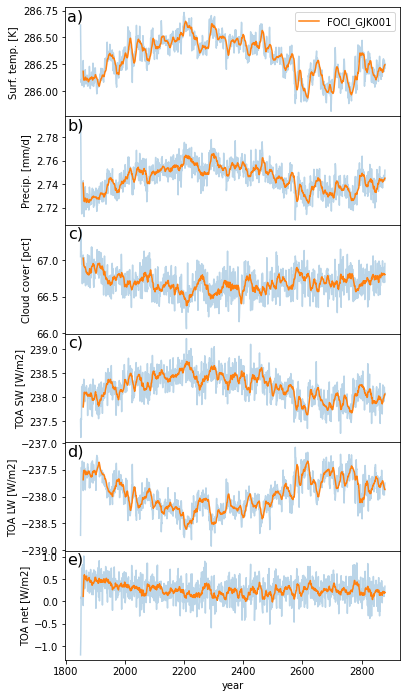

In [25]:
# Fluxes need to be scaled 
# They are stored in e.g. W/m2 * s
# So we divide by the frequency of XIOS call (usually 3hr for T95)
# For long climate runs we may use 24hr
flux_scale = 1./(6 * 60 * 60)

# Scale precip from m/s to mm/d
pr_scale = 1000. * 86400. * flux_scale

fig1, ax1 = plt.subplots(6,1,figsize=(6,12))

for i,(ds_sfc,exp) in enumerate( zip(ds_sfc_all, exp_list) ):
    
    # Read 2m temp
    t2m = ds_sfc['2t']
    # Precip
    pr = ds_sfc['tp'] * pr_scale
    # Cloud cover
    tcc = ds_sfc['tcc'] * 100
    # TOA SW
    tsr = ds_sfc['tsr'] * flux_scale
    # TOA LW
    ttr = ds_sfc['ttr'] * flux_scale
    
    # Weighted global mean
    weights = np.cos(np.deg2rad(t2m.lat))
    weights.name = "weights"
    
    t2m_wgt = t2m.weighted(weights)
    t2m_mean = t2m_wgt.mean(('lon','lat'))
    
    pr_wgt = pr.weighted(weights)
    pr_mean = pr_wgt.mean(('lon','lat'))
    
    tcc_wgt = tcc.weighted(weights)
    tcc_mean = tcc_wgt.mean(('lon','lat'))
    
    tsr_wgt = tsr.weighted(weights)
    tsr_mean = tsr_wgt.mean(('lon','lat'))
    
    ttr_wgt = ttr.weighted(weights)
    ttr_mean = ttr_wgt.mean(('lon','lat'))
    
    # Net TOA
    toa_mean = tsr_mean + ttr_mean
    print(toa_mean)
    
    # Annual mean
    t2m = t2m_mean.groupby('time.year').mean('time')
    t2m.plot(ax=ax1[0],alpha=0.3)
    t2m.rolling(year=10).mean().plot(ax=ax1[0],alpha=1,label=exp)
    
    pr = pr_mean.groupby('time.year').mean('time')
    pr.plot(ax=ax1[1],alpha=0.3)
    pr.rolling(year=10).mean().plot(ax=ax1[1],alpha=1)
    
    tcc = tcc_mean.groupby('time.year').mean('time')
    tcc.plot(ax=ax1[2],alpha=0.3)
    tcc.rolling(year=10).mean().plot(ax=ax1[2],alpha=1)
    
    tsr = tsr_mean.groupby('time.year').mean('time')
    tsr.plot(ax=ax1[3],alpha=0.3)
    tsr.rolling(year=10).mean().plot(ax=ax1[3],alpha=1)
    
    ttr = ttr_mean.groupby('time.year').mean('time')
    ttr.plot(ax=ax1[4],alpha=0.3)
    ttr.rolling(year=10).mean().plot(ax=ax1[4],alpha=1)
    
    toa = toa_mean.groupby('time.year').mean('time')
    toa.plot(ax=ax1[5],alpha=0.3)
    toa.rolling(year=10).mean().plot(ax=ax1[5],alpha=1)
    
for ax in [ax1]:
    ax[0].legend()
    ax[0].set_ylabel('Surf. temp. [K]')
    ax[1].set_ylabel('Precip. [mm/d]')
    ax[2].set_ylabel('Cloud cover [pct]')
    ax[3].set_ylabel('TOA SW [W/m2]')
    ax[4].set_ylabel('TOA LW [W/m2]')
    ax[5].set_ylabel('TOA net [W/m2]')
    
    ax[0].text(0.03, 0.92, 'a)', fontsize=16, 
               horizontalalignment='center', 
               verticalalignment='center', transform=ax[0].transAxes)
    ax[1].text(0.03, 0.92, 'b)', fontsize=16, 
               horizontalalignment='center', 
               verticalalignment='center', transform=ax[1].transAxes)
    ax[2].text(0.03, 0.92, 'c)', fontsize=16, 
               horizontalalignment='center', 
               verticalalignment='center', transform=ax[2].transAxes)
    ax[3].text(0.03, 0.92, 'c)', fontsize=16, 
               horizontalalignment='center', 
               verticalalignment='center', transform=ax[3].transAxes)
    ax[4].text(0.03, 0.92, 'd)', fontsize=16, 
               horizontalalignment='center', 
               verticalalignment='center', transform=ax[4].transAxes)
    ax[5].text(0.03, 0.92, 'e)', fontsize=16, 
               horizontalalignment='center', 
               verticalalignment='center', transform=ax[5].transAxes)
    
for ax in ax1:
    ax.set_title('')
    #ax.axis["right"].set_visible(False)
    
for ax in ax1[:-1]:
    ax.set_xlabel('')
    ax.set_xticklabels([])
    #ax.axis["bottom"].set_visible(False)
    #ax.axis["top"].set_visible(False)

#ax1[-1].axis["top"].set_visible(False)
    
#fig1.tight_layout()
fig1.subplots_adjust(hspace=0.0) #, right=0.8, top=0.9)
fig1.savefig('Fig1.pdf',format='pdf')

## SST bias

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:73: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


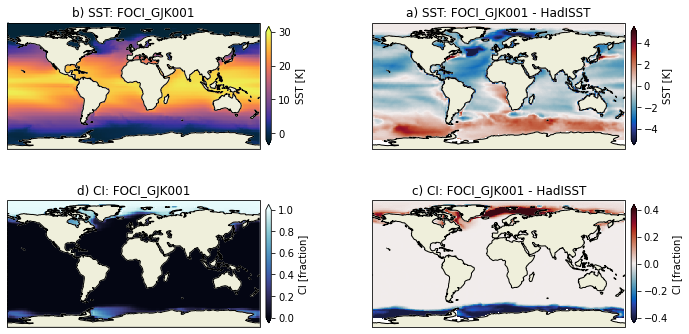

In [26]:
# Plot settings
prj = ccrs.PlateCarree()
tmin1 = -2
tmax1 = 30
tmin2 = -5
tmax2 = 5
cmin1 = 0
cmax1 = 1
cmin2 = -0.4
cmax2 = 0.4

cmap1 = cmocean.cm.thermal
cmap2 = cmocean.cm.balance
imap1 = cmocean.cm.ice
imap2 = cmocean.cm.balance

# HadSST and ice
if machine == 'sci':
    hadisst = '/data/user/swahl/reanalysis_obs/HADISST/HadISST_sst.nc'
    hadiice = '/data/user/swahl/reanalysis_obs/HADISST/HadISST_ice.nc'
elif machine == 'nesh':
    hadisst = '/gxfs_work1/geomar/smomw352/reanalysis_obs/HadISST_sst.nc'
    hadiice = '/gxfs_work1/geomar/smomw352/reanalysis_obs/HadISST_ice.nc'

ds_hadsst = xr.open_dataset(hadisst).rename({'longitude':'lon','latitude':'lat'})
ds_hadice = xr.open_dataset(hadiice).rename({'longitude':'lon','latitude':'lat'})

sst_had = ds_hadsst['sst'].where(ds_hadsst['sst'] > -50)
sst_had = sst_had.sel(time=slice('1980-01-01','2010-01-01')).mean('time')
sic_had = ds_hadice['sic'].sel(time=slice('1980-01-01','2010-01-01')).mean('time')

for i, (ds_sfc,exp) in enumerate( zip(ds_sfc_all, exp_list) ):
    exp = exp_list[i]
    ds_sfc = ds_sfc_all[i]
    
    # Convert SST to Celsius and CI to percent
    sst = ds_sfc['sstk'].mean('time') - 273.15
    ci  = ds_sfc['ci'].mean('time') 
    
    sst_180 = sst.assign_coords(lon=(((sst.lon + 180) % 360) - 180))
    ci_180  = ci.assign_coords(lon=(((ci.lon + 180) % 360) - 180))
    
    sst_i = sst_180.interp_like(sst_had)
    ci_i  = ci_180.interp_like(sic_had)
    
    if 1:
        fig = plt.figure(figsize=(12,6))
        axs = []
        axs.append( fig.add_subplot(2,2,1,projection=prj) )
        axs.append( fig.add_subplot(2,2,2,projection=prj) )
        axs.append( fig.add_subplot(2,2,3,projection=prj) )
        axs.append( fig.add_subplot(2,2,4,projection=prj) )
        
        for ax in axs: ax.add_feature(cfeature.LAND,zorder=1)
        
        ckw = {'shrink':0.8, 'pad':0.02, 'extend':'both', 'label':'SST [K]'}
        sst.plot(ax=axs[0],vmin=tmin1,vmax=tmax1,cmap=cmap1,cbar_kwargs=ckw)
        (sst_i - sst_had).plot(ax=axs[1],cmap=cmap2,vmin=tmin2,vmax=tmax2,cbar_kwargs=ckw)
        
        ckw = {'shrink':0.8, 'pad':0.02, 'extend':'both', 'label':'CI [fraction]'}
        ci.plot(ax=axs[2],vmin=cmin1,vmax=cmax1,cmap=imap1,cbar_kwargs=ckw)
        (ci_i - sic_had).plot(ax=axs[3],cmap=imap2,vmin=cmin2,vmax=cmax2,cbar_kwargs=ckw)
        
        axs[1].set_title('a) SST: %s - HadISST' % (exp,))
        axs[0].set_title('b) SST: %s' % (exp,))
        axs[3].set_title('c) CI: %s - HadISST' % (exp,))
        axs[2].set_title('d) CI: %s' % (exp,))
        
        for ax in axs:
            ax.coastlines()
            #ax.set_extent([-100,30,10,90],crs=prj)
        
        fig.tight_layout()
        fig.savefig('Fig2_SST_biases.pdf',format='pdf')
